1. Getting data ready ->	Data can be almost anything but to get started we're going to create a simple straight line
2. Building a model ->	Here we'll create a model to learn patterns in the data, we'll also choose a loss function, optimizer and build a training loop.
3. Fitting the model to data (training) ->	We've got data and a model, now let's let the model (try to) find patterns in the (training) data.
4. Making predictions and evaluating a model (inference) ->	Our model's found patterns in the data, let's compare its findings to the actual (testing) data.
5. Saving and loading a model ->	You may want to use your model elsewhere, or come back to it later, here we'll cover that.
6. Putting it all together ->	Let's take all of the above and combine it.

In [23]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'2.6.0+cu124'

# Data (preparing and loading)

In [24]:
# Creating our own data
#known parameters
weight = 0.7
bias = 0.3

# Create X (features) and y (labels)
X = torch.arange(0,1,0.02).unsqueeze(dim=1)
y = weight * X + bias

X,y

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800],
         [0.2000],
         [0.2200],
         [0.2400],
         [0.2600],
         [0.2800],
         [0.3000],
         [0.3200],
         [0.3400],
         [0.3600],
         [0.3800],
         [0.4000],
         [0.4200],
         [0.4400],
         [0.4600],
         [0.4800],
         [0.5000],
         [0.5200],
         [0.5400],
         [0.5600],
         [0.5800],
         [0.6000],
         [0.6200],
         [0.6400],
         [0.6600],
         [0.6800],
         [0.7000],
         [0.7200],
         [0.7400],
         [0.7600],
         [0.7800],
         [0.8000],
         [0.8200],
         [0.8400],
         [0.8600],
         [0.8800],
         [0.9000],
         [0.9200],
         [0.9400],
         [0.9600],
         [0.9800]]),
 tensor([[0.3000],
         [0.3140],
         [

In [25]:
# Splitting the data into train and test
split = 0.8 * len(X)
split = int(split)
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]
len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

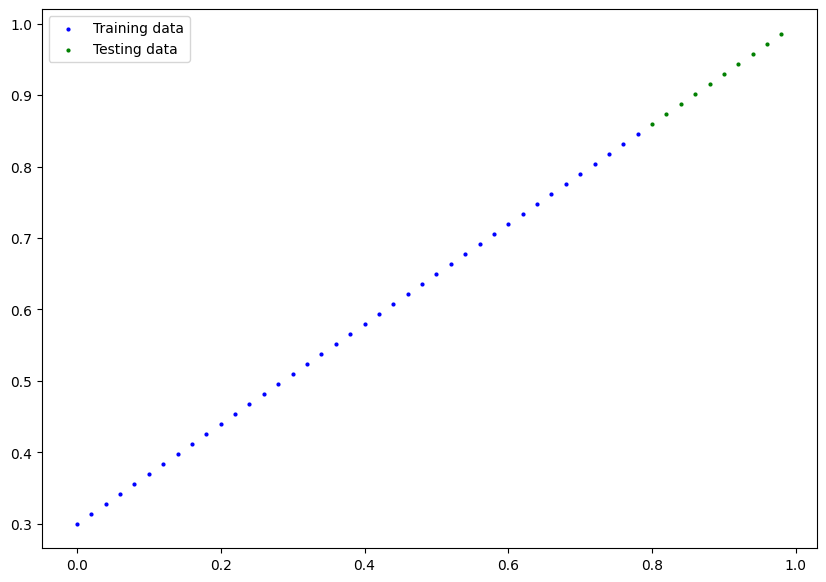

In [26]:
def plot_predictions(train_data = X_train,
                     test_data = X_test,
                     train_labels = y_train,
                     test_labels = y_test,
                     predictions = None):
  plt.figure(figsize=(10,7))
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")
  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
  plt.legend()
  plt.show()


plot_predictions()

# Build model

In [27]:
class LinearRegressionModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1,#start with random weight
                                            dtype=torch.float,#PyTorch loves float32 by default
                                requires_grad=True)) #Update value with gradient descent
    self.bias = nn.Parameter(torch.randn(1,dtype=torch.float,requires_grad=True))

  def forward(self,x:torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias

1. torch.nn ->	Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way).
2. torch.nn.Parameter ->	Stores tensors that can be used with nn.Module. If requires_grad=True gradients (used for updating model parameters via gradient descent) are calculated automatically, this is often referred to as "autograd".
3. torch.nn.Module ->	The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass nn.Module. Requires a forward() method be implemented.
4. torch.optim ->	Contains various optimization algorithms (these tell the model parameters stored in nn.Parameter how to best change to improve gradient descent and in turn reduce the loss).
5. def forward() ->	All nn.Module subclasses require a forward() method, this defines the computation that will take place on the data passed to the particular nn.Module (e.g. the linear regression formula above).

In [28]:
# Set manual seed since nn.Parameter are randomly initialized
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [29]:
# List named parameters
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [30]:
# Make predictions with model
with torch.inference_mode():
    y_preds = model_0(X_test)

In [31]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}")
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([[0.3982],
        [0.4049],
        [0.4116],
        [0.4184],
        [0.4251],
        [0.4318],
        [0.4386],
        [0.4453],
        [0.4520],
        [0.4588]])


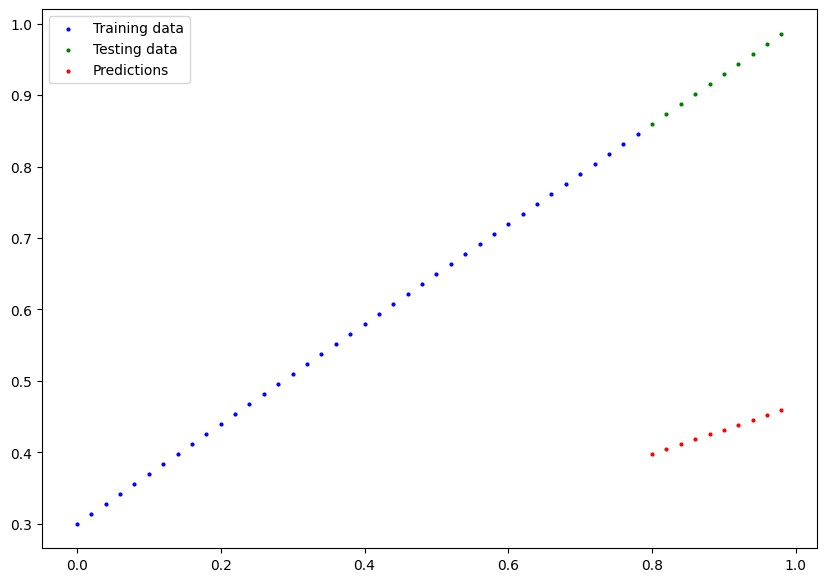

In [32]:
plot_predictions(predictions=y_preds)

In [33]:
y_test - y_preds

tensor([[0.4618],
        [0.4691],
        [0.4764],
        [0.4836],
        [0.4909],
        [0.4982],
        [0.5054],
        [0.5127],
        [0.5200],
        [0.5272]])

# Train model

For our model to update its parameters on its own, we'll need to add a few more things to our recipe.

And that's a loss function as well as an optimizer.

1. Loss function ->	Measures how wrong your model's predictions (e.g. y_preds) are compared to the truth labels (e.g. y_test). Lower the better.
PyTorch has plenty of built-in loss functions in torch.nn. 	Mean absolute error (MAE) for regression problems (torch.nn.L1Loss()).

Binary cross entropy for binary classification problems (torch.nn.BCELoss()).

2. Optimizer ->	Tells your model how to update its internal parameters to best lower the loss.
You can find various optimization function implementations in torch.optim. 	Stochastic gradient descent (torch.optim.SGD()).

Adam optimizer (torch.optim.Adam()).

In [34]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

**PyTorch training loop**

For the training loop, we'll build the following steps:

1. 	Forward pass ->	The model goes through all of the training data once, performing its forward() function calculations. 	model(x_train)
2. 	Calculate the loss ->	The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. 	loss = loss_fn(y_pred, y_train)
3. 	Zero gradients ->	The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step. 	optimizer.zero_grad()
4. 	Perform backpropagation on the loss ->	Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with requires_grad=True). This is known as backpropagation, hence "backwards". 	loss.backward()
5. 	Update the optimizer (gradient descent) ->	Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them. 	optimizer.step()


**PyTorch testing loop**

As for the testing loop (evaluating our model), the typical steps include:

1.	Forward pass ->	The model goes through all of the testing data once, performing its forward() function calculations. 	model(x_test)
2. 	Calculate the loss ->	The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. 	loss = loss_fn(y_pred, y_test)
3. 	Calulate evaluation metrics (optional) ->	Alongside the loss value you may want to calculate other evaluation metrics such as accuracy on the test set. 	Custom functions

In [35]:
torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 100

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer
    optimizer.step()

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()

    with torch.inference_mode():
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819 


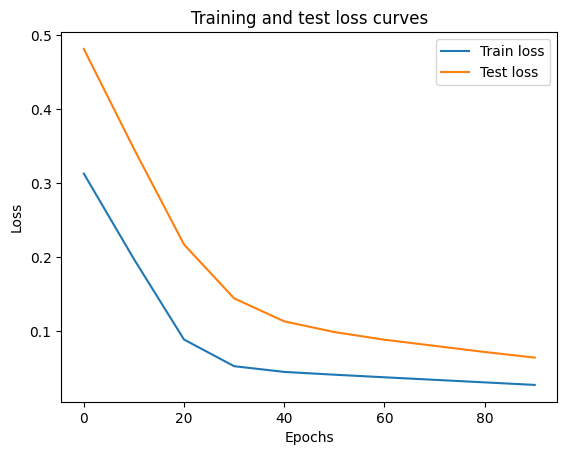

In [36]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [37]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


# Making predictions with a trained PyTorch model (inference)

In [38]:
# 1. Set the model in evaluation mode
model_0.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  # in our case, we haven't setup device-agnostic code yet so our data and model are
  # on the CPU by default.
  # model_0.to(device)
  # X_test = X_test.to(device)
  y_preds = model_0(X_test)
y_preds

tensor([[0.8141],
        [0.8256],
        [0.8372],
        [0.8488],
        [0.8603],
        [0.8719],
        [0.8835],
        [0.8950],
        [0.9066],
        [0.9182]])

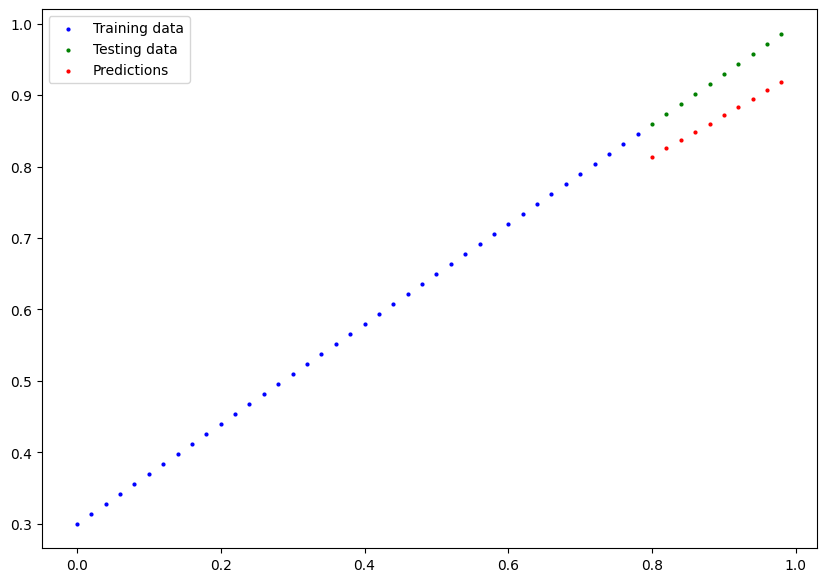

In [39]:
plot_predictions(predictions=y_preds)

# Saving and loading a PyTorch model

1. torch.save ->	Saves a serialized object to disk using Python's pickle utility. Models, tensors and various other Python objects like dictionaries can be saved using torch.save.
2. torch.load ->	Uses pickle's unpickling features to deserialize and load pickled Python object files (like models, tensors or dictionaries) into memory. You can also set which device to load the object to (CPU, GPU etc).
3. torch.nn.Module.load_state_dict ->	Loads a model's parameter dictionary (model.state_dict()) using a saved state_dict() object.

In [40]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: 01_pytorch_workflow_model_0.pth


In [41]:
# Check the saved file path
!ls -l 01_pytorch_workflow_model_0.pth

-rw-r--r-- 1 root root 1680 Jun  2 10:56 01_pytorch_workflow_model_0.pth


In [42]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

In [43]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

In [44]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])